# Fully connected Auto-Encoder for Tabular Data
In order to compare the classical and quantum methods we will implement several methods including the deep learning method, fully connected auto-encoder. 

### Imports

In [580]:
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix

#Auto-encoder imports
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#DataSets that we can test
vowel = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.data'
iris = load_iris()
breast_cancer = load_breast_cancer()

name_datasets_sklearn = {'iris_data': iris, 'breast_cancer_data': breast_cancer}

# TODO: some error because of the location of the file
# from ipynb.fs.full.EDA import vowelData
# from ipynb.fs.full.EDA import irisData
# from ipynb.fs.full.EDA import breastcancerData

### Load data

In [581]:
vowel_data = pd.read_csv(vowel, index_col=False, delim_whitespace=True, header=None)
iris_data = pd.DataFrame(np.concatenate((name_datasets_sklearn["iris_data"]["data"], name_datasets_sklearn["iris_data"]["target"].reshape(-1,1)), axis=1))
breast_cancer_data = pd.DataFrame(np.concatenate((name_datasets_sklearn["breast_cancer_data"]["data"], name_datasets_sklearn["breast_cancer_data"]["target"].reshape(-1,1)), axis=1))
datasets = [vowel_data, iris_data, breast_cancer_data]

In [582]:
def get_dataloaders(dataset, normal_classes, anomaly_classes, batch_size=64, normal_test_percentage=0.1, seed=42):
    normal_data = dataset.copy()
    anomaly_data = dataset.copy()

    # isolate normal classes
    normal_data = normal_data[normal_data.iloc[:,-1].isin(normal_classes)].to_numpy()
    normal_data[:,-1] = 0

    # isolate anomaly classes
    anomaly_data = anomaly_data[anomaly_data.iloc[:,-1].isin(anomaly_classes)].to_numpy()
    anomaly_data[:,-1] = 1

    # split the data into train and test with the `normal_test_percentage` of the normal data being in the test set
    # together with all of the anomalies
    len_normal = normal_data.shape[0]
    train_size = int(len_normal * (1-normal_test_percentage))
    test_normal_size = len_normal - train_size

    train_data, test_data = torch.utils.data.random_split(normal_data, [train_size, test_normal_size], generator=torch.Generator().manual_seed(seed))
    test_data = np.concatenate([test_data, anomaly_data])

    train_data = np.array(train_data, dtype=np.float32)
    test_data = np.array(test_data, dtype=np.float32)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    
    return train_loader, test_loader

### Autoencoder

In [583]:
# Define the autoencoder class
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size//4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size//4, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train(self, train_loader, normal_classes, anomaly_classes, n_epochs=50, criterion=nn.MSELoss()):
        optimizer = optim.Adam(self.parameters(), lr=0.005)

        for epoch in range(n_epochs):
            for batch in train_loader:

                X = batch[:, :-1] # drop the label

                # Forward pass
                output = self(X)
                loss = criterion(output, X)
                
                # Backward pass and optimization step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
                
            # Print the loss for this epoch
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

    def get_reconstruction_errors(self, loader):
        diffs = np.array([])
        all_labels = np.array([])
        for data in loader:
            labels = data[:,-1]
            data = data[:,:-1]
            rec_data = self(data)
            rec_error = torch.sum((data - rec_data)**2, axis=1)
            diffs = np.concatenate((diffs, rec_error.detach().numpy()))
            all_labels = np.concatenate((all_labels, labels.detach().numpy()))
        return diffs, all_labels

    def classify(self, loader, threshold):
        errors, labels = self.get_reconstruction_errors(loader)
        preds = np.where(errors > threshold, 1, 0)
        return preds, labels

In [584]:
data = vowel_data
model = AutoEncoder(data.shape[1]-1, 12)
train_loader, test_loader = get_dataloaders(data, [0,1], [2,3])
model.train(train_loader, [0], [8])
errors, labels = model.get_reconstruction_errors(test_loader)
np.mean(errors[labels==0]), np.mean(errors[labels==1])

Epoch [1/50], Loss: 5.3764
Epoch [2/50], Loss: 5.2431
Epoch [3/50], Loss: 5.1067
Epoch [4/50], Loss: 4.9580
Epoch [5/50], Loss: 4.7855
Epoch [6/50], Loss: 4.5801
Epoch [7/50], Loss: 4.3334
Epoch [8/50], Loss: 4.0349
Epoch [9/50], Loss: 3.6727
Epoch [10/50], Loss: 3.2340
Epoch [11/50], Loss: 2.7142
Epoch [12/50], Loss: 2.1424
Epoch [13/50], Loss: 1.6581
Epoch [14/50], Loss: 1.4634
Epoch [15/50], Loss: 1.3500
Epoch [16/50], Loss: 1.1186
Epoch [17/50], Loss: 0.9887
Epoch [18/50], Loss: 0.9543
Epoch [19/50], Loss: 0.9076
Epoch [20/50], Loss: 0.8448
Epoch [21/50], Loss: 0.8040
Epoch [22/50], Loss: 0.7610
Epoch [23/50], Loss: 0.6950
Epoch [24/50], Loss: 0.6433
Epoch [25/50], Loss: 0.6106
Epoch [26/50], Loss: 0.5847
Epoch [27/50], Loss: 0.5671
Epoch [28/50], Loss: 0.5482
Epoch [29/50], Loss: 0.5326
Epoch [30/50], Loss: 0.5238
Epoch [31/50], Loss: 0.5182
Epoch [32/50], Loss: 0.5154
Epoch [33/50], Loss: 0.5123
Epoch [34/50], Loss: 0.5079
Epoch [35/50], Loss: 0.5031
Epoch [36/50], Loss: 0.4985
E

(5.482502341270447, 6.1766612543000114)

In [585]:
model.classify(test_loader, 4.5)

(array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 

In [587]:
def accuracy_score(preds, labels):
    return np.sum(preds == labels)/len(preds)

def precision_score(preds, labels):
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    return tp/(tp + fp)

def recall_score(preds, labels):
    tp = np.sum((preds == 1) & (labels == 1))
    fn = np.sum((preds == 0) & (labels == 1))
    return tp/(tp + fn)

def f1_score(preds, labels):
    prec = precision_score(preds, labels)
    rec = recall_score(preds, labels)
    return 2 * prec * rec / (prec + rec)

def statistics(preds, labels):
    return {
        "accuracy": accuracy_score(preds, labels),
        "precision": precision_score(preds, labels),
        "recall": recall_score(preds, labels),
        "f1": f1_score(preds, labels)
    }

def plot_distribution_reconstruction(preds, labels):
    sns.kdeplot(preds[labels==0], shade=True, label="Normal")
    sns.kdeplot(preds[labels==1], shade=True, label="Anomaly")
    plt.xlabel("Reconstruction error")
    plt.ylabel("Density")
    plt.show()


def plot_precision_recall_curve(preds, labels, maximum_threshold=10):
    precisions = []
    recalls = []
    thresholds = np.linspace(0, maximum_threshold, 100) 
    for threshold in thresholds:
        preds = np.where(errors > threshold, 1, 0)
        precisions.append(precision_score(preds, labels))
        recalls.append(recall_score(preds, labels))
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    
def print_statistics(preds, labels):
    stats = statistics(preds, labels)
    print("Accuracy:", stats["accuracy"])
    print("Precision:", stats["precision"])
    print("Recall:", stats["recall"])
    print("F1:", stats["f1"])    

def plot_confusion_matrix(preds, labels):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
print_statistics(*model.classify(test_loader, 4.5))

Accuracy: 0.702020202020202
Precision: 0.9416058394160584
Recall: 0.7166666666666667
F1: 0.8138801261829652


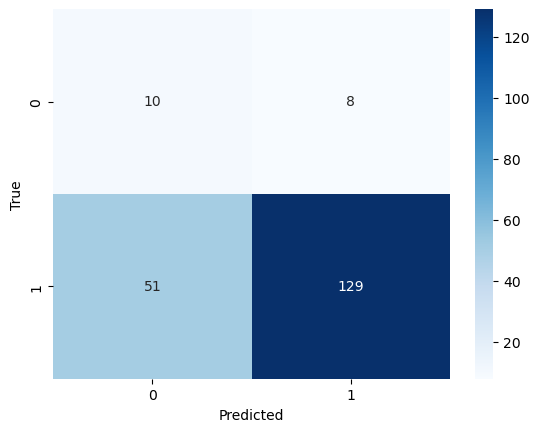

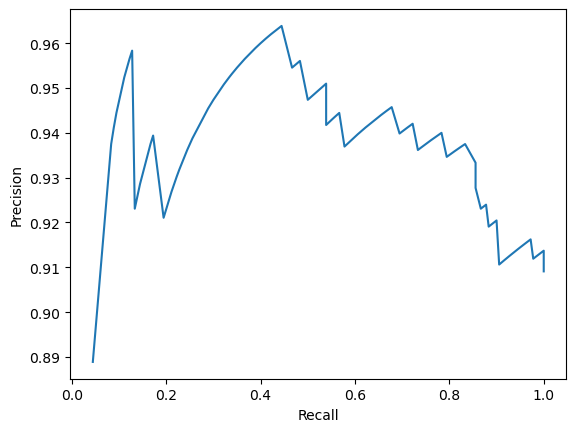

In [ ]:
plot_confusion_matrix(*model.classify(test_loader, 4.5))
plot_precision_recall_curve(*model.classify(test_loader, 4.5))


/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_18026/1367245479.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(preds[labels==0], shade=True, label="Normal")
/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_18026/1367245479.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(preds[labels==1], shade=True, label="Anomaly")


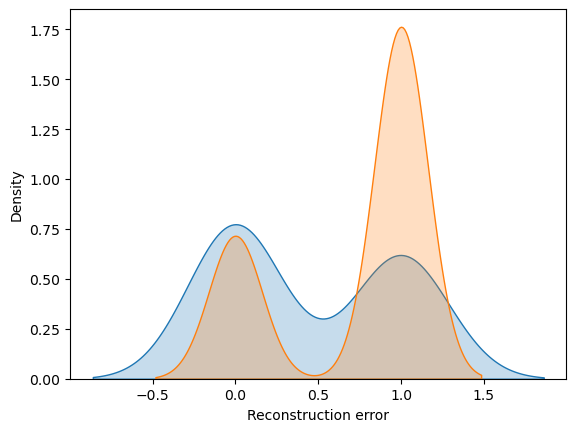

In [590]:
plot_distribution_reconstruction(*model.classify(test_loader, 4.5))

# Combined pipeline

In [ ]:
def everything(data, normal_classes, anomaly_classes, normal_test_percentage, threshold, maximum_threshold):
    model = AutoEncoder(data.shape[1]-1, 12)
    train_loader, test_loader = get_dataloaders(data, normal_classes, anomaly_classes, normal_test_percentage=normal_test_percentage)
    model.train(train_loader, normal_classes, anomaly_classes)
    errors, labels = model.get_reconstruction_errors(test_loader)
    print(np.mean(errors[labels==0]), np.mean(errors[labels==1]))
    preds, labels = model.classify(test_loader, threshold)
    print_statistics(preds, labels)
    plot_confusion_matrix(preds, labels)
    plot_precision_recall_curve(preds, labels, maximum_threshold=maximum_threshold)
    plot_distribution_reconstruction(preds, labels)

## Iris dataset

Epoch [1/50], Loss: 13.1652
Epoch [2/50], Loss: 12.9416
Epoch [3/50], Loss: 12.7243
Epoch [4/50], Loss: 12.4969
Epoch [5/50], Loss: 12.2552
Epoch [6/50], Loss: 12.0038
Epoch [7/50], Loss: 11.7322
Epoch [8/50], Loss: 11.4479
Epoch [9/50], Loss: 11.1429
Epoch [10/50], Loss: 10.8089
Epoch [11/50], Loss: 10.4248
Epoch [12/50], Loss: 9.9787
Epoch [13/50], Loss: 9.4571
Epoch [14/50], Loss: 8.8460
Epoch [15/50], Loss: 8.1163
Epoch [16/50], Loss: 7.2521
Epoch [17/50], Loss: 6.2495
Epoch [18/50], Loss: 5.1188
Epoch [19/50], Loss: 3.9056
Epoch [20/50], Loss: 2.7017
Epoch [21/50], Loss: 1.6676
Epoch [22/50], Loss: 1.0517
Epoch [23/50], Loss: 1.0823
Epoch [24/50], Loss: 1.4408
Epoch [25/50], Loss: 1.4482
Epoch [26/50], Loss: 1.0753
Epoch [27/50], Loss: 0.6932
Epoch [28/50], Loss: 0.5067
Epoch [29/50], Loss: 0.4946
Epoch [30/50], Loss: 0.5528
Epoch [31/50], Loss: 0.5997
Epoch [32/50], Loss: 0.6022
Epoch [33/50], Loss: 0.5653
Epoch [34/50], Loss: 0.5141
Epoch [35/50], Loss: 0.4764
Epoch [36/50], Los

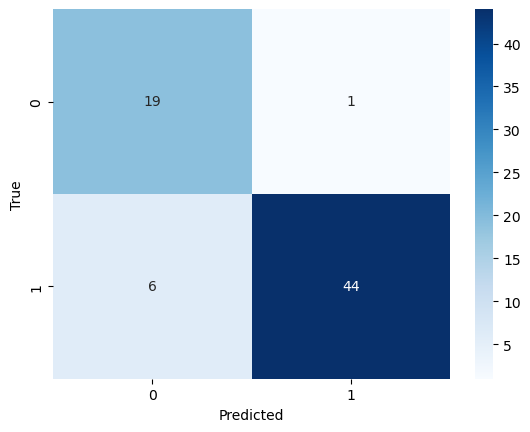

ValueError: operands could not be broadcast together with shapes (198,) (70,) 

In [ ]:
everything(data = iris_data, 
           normal_classes = [0,1],
           anomaly_classes = [2], 
           normal_test_percentage = 0.2,
           threshold = 3, 
           maximum_threshold = 10)

### Breast cancer dataset

Epoch [1/50], Loss: 131076.1562
Epoch [2/50], Loss: 131037.1484
Epoch [3/50], Loss: 130885.7891
Epoch [4/50], Loss: 130499.8750
Epoch [5/50], Loss: 129687.3906
Epoch [6/50], Loss: 128186.5625
Epoch [7/50], Loss: 125655.6719
Epoch [8/50], Loss: 121525.4141
Epoch [9/50], Loss: 115139.9062
Epoch [10/50], Loss: 105662.4688
Epoch [11/50], Loss: 92319.1719
Epoch [12/50], Loss: 74686.6484
Epoch [13/50], Loss: 53410.3555
Epoch [14/50], Loss: 32562.8652
Epoch [15/50], Loss: 21714.3828
Epoch [16/50], Loss: 21069.7676
Epoch [17/50], Loss: 13133.1553
Epoch [18/50], Loss: 5234.0161
Epoch [19/50], Loss: 3330.3584
Epoch [20/50], Loss: 3229.6536
Epoch [21/50], Loss: 2334.2024
Epoch [22/50], Loss: 1530.6146
Epoch [23/50], Loss: 1787.0236
Epoch [24/50], Loss: 2063.8999
Epoch [25/50], Loss: 1642.3099
Epoch [26/50], Loss: 1312.7048
Epoch [27/50], Loss: 1262.0044
Epoch [28/50], Loss: 1109.4077
Epoch [29/50], Loss: 893.3299
Epoch [30/50], Loss: 846.9325
Epoch [31/50], Loss: 888.3131
Epoch [32/50], Loss: 864

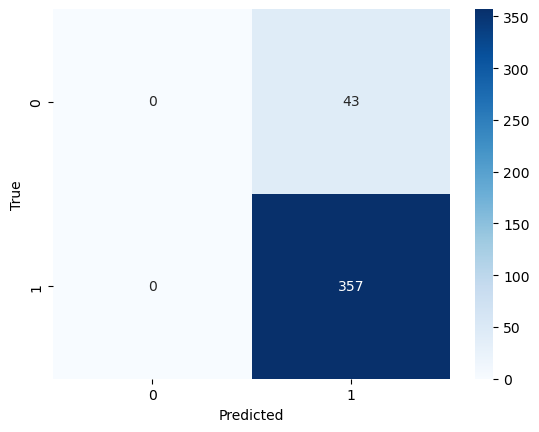

ValueError: operands could not be broadcast together with shapes (198,) (400,) 

In [ ]:
everything(data = breast_cancer_data, 
           normal_classes = [0],
           anomaly_classes = [1], 
           normal_test_percentage = 0.2,
           threshold = 0.5, 
           maximum_threshold = 10)

In [ ]:
"""
Look at the distribution of the reconstruction errors for the normal and anomalous classes.
Contruct two distributions and see what the overlap is.
If gaussian, use formula > intersection of gaussians


For different thresholds, plot the precision-recall curve.

Normalize data

Check for papers of anomaly detection on the datasets

Else: Initial tests show that this is reasonable

Add sliders to confusion matrix
"""

### Vowel Dataset

In [ ]:
everything(data = vowel_data,
           normal_classes = [0,1],
           anomaly_classes = [8], 
           normal_test_percentage = 0.2,
           threshold = 4.5, 
           maximum_threshold = 10)

SyntaxError: invalid syntax (610013929.py, line 1)